# Random Forest

## 1. Import Libraries and Setup

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve
)

# set random seed
np.random.seed(42)

## 2. Load Dataset

In [17]:
# Load the dataset
df = pd.read_csv('churn_data_cleaned.csv')

## 3. Prepare Train-Test Split

Split the data into training (80%) and testing (20%) sets with stratification to maintain class distribution.

In [ ]:
# Separate features and target
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class distribution
)

## 4. Handle Class Imbalance

Calculate class weights to address the imbalanced dataset. The model will pay more attention to the minority class (churners) during training.

In [ ]:
# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}

## 5. Define Hyperparameter Grid

Set up the parameter combinations to test using GridSearchCV. We'll optimize for precision to minimize false positives.

In [18]:
# Import cross-validation tools
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

print("Setting up hyperparameter grid for Random Forest")

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [50, 100, 200],
    'min_samples_leaf': [25, 50, 100],
}

print(f"\nTotal combinations to test: {np.prod([len(v) for v in param_grid.values()])}")

Setting up hyperparameter grid for Random Forest

Total combinations to test: 81


## 6. Perform 5-Fold Cross-Validation

Train the Random Forest model using 5-fold cross-validation with grid search to find the best hyperparameters.

In [ ]:
# Set up 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create base Random Forest model
rf_base = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Set up GridSearchCV with Precision as the metric
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=cv,
    scoring='precision',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Perform grid search on training data
grid_search.fit(X_train, y_train)

print("Grid search complete.")

## 7. Display Cross-Validation Results

Show the best parameters found and the top 5 parameter combinations based on precision score.

In [30]:
# Display best parameters and cross-validation results
print("\nBest Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Precision Score: {grid_search.best_score_:.4f}")

# Display top 5 parameter combinations
cv_results = pd.DataFrame(grid_search.cv_results_)
top_results = cv_results.sort_values('rank_test_score').head(5)[
    ['params', 'mean_test_score', 'std_test_score', 'mean_train_score', 'rank_test_score']
]

print("\nTop 5 Parameter Combinations:")
for idx, row in top_results.iterrows():
    print(f"  Parameters: {row['params']}")
    print(f"  CV Precision Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"  Train Precision Score: {row['mean_train_score']:.4f}")
    print("\n")


Best Parameters Found:
  max_depth: 20
  min_samples_leaf: 25
  min_samples_split: 50
  n_estimators: 200

Best Cross-Validation Precision Score: 0.2118

Top 5 Parameter Combinations:
  Parameters: {'max_depth': 20, 'min_samples_leaf': 25, 'min_samples_split': 50, 'n_estimators': 200}
  CV Precision Score: 0.2118 (+/- 0.0033)
  Train Precision Score: 0.2895


  Parameters: {'max_depth': 20, 'min_samples_leaf': 25, 'min_samples_split': 50, 'n_estimators': 100}
  CV Precision Score: 0.2105 (+/- 0.0031)
  Train Precision Score: 0.2885


  Parameters: {'max_depth': 20, 'min_samples_leaf': 25, 'min_samples_split': 50, 'n_estimators': 50}
  CV Precision Score: 0.2084 (+/- 0.0034)
  Train Precision Score: 0.2846


  Parameters: {'max_depth': 20, 'min_samples_leaf': 25, 'min_samples_split': 100, 'n_estimators': 200}
  CV Precision Score: 0.2023 (+/- 0.0024)
  Train Precision Score: 0.2585


  Parameters: {'max_depth': 20, 'min_samples_leaf': 25, 'min_samples_split': 100, 'n_estimators': 100}


## 8. Extract Final Model

Retrieve the best model from grid search, already trained with optimal parameters.

In [24]:
# Get the best model from grid search
rf_model = grid_search.best_estimator_

print(f"Number of trees: {rf_model.n_estimators}")
print(f"Number of features: {rf_model.n_features_in_}")

Number of trees: 200
Number of features: 30


## 9. Evaluate Model Performance

Make predictions on the test set and calculate performance metrics.

In [28]:
# Make predictions on test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate metrics
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

# Calculate individual metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("Performance Metrics")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1 Score:   {f1:.4f}")
print(f"AUC-ROC:    {auc_roc:.4f}")


Random Forest Classification Report:
              precision    recall  f1-score   support

    No Churn       0.96      0.80      0.87     65253
       Churn       0.21      0.59      0.31      5785

    accuracy                           0.78     71038
   macro avg       0.58      0.70      0.59     71038
weighted avg       0.90      0.78      0.83     71038

Performance Metrics
Precision:  0.2083
Recall:     0.5948
F1 Score:   0.3086
AUC-ROC:    0.7898


## 10. Visualize Results

Plot confusion matrix and ROC curve to visualize model performance.

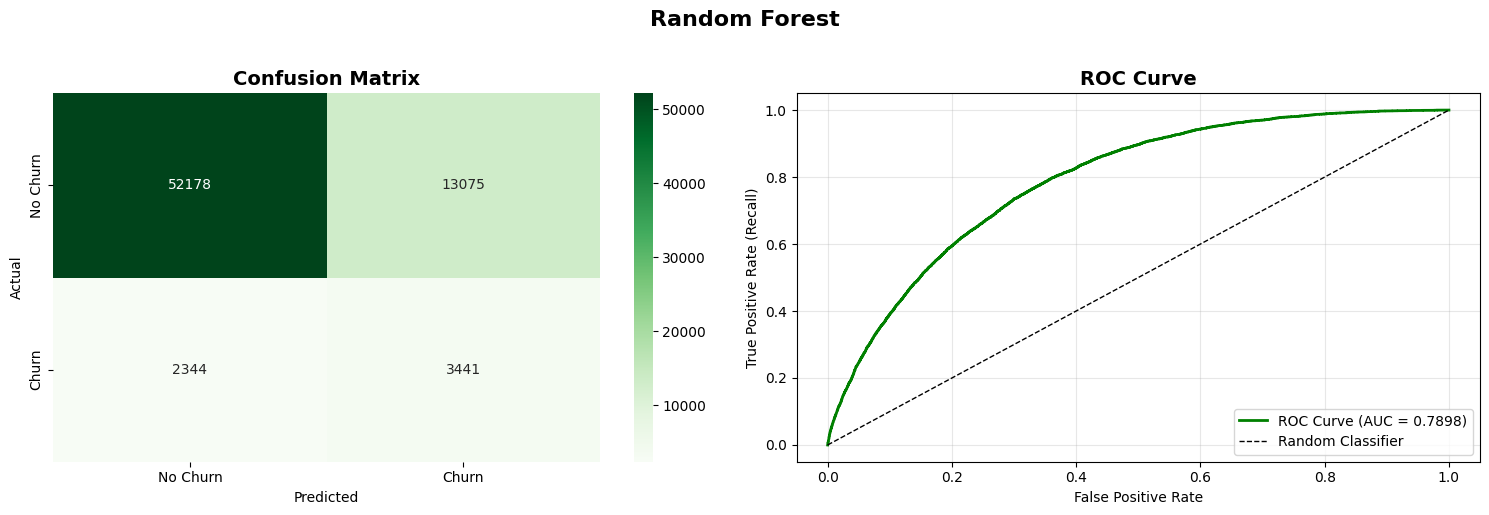

In [29]:
# Plot confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Random Forest', fontsize=16, fontweight='bold', y=1.02)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['No Churn', 'Churn'])
axes[0].set_yticklabels(['No Churn', 'Churn'])

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_roc:.4f})', color='green')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate (Recall)')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()